# Multi-armed bandit demo
Here we implement the following algorithms for solving multi-armed bandit problems:
  * $\epsilon$-greedy
  * Upper confidence bound (UCB1)
    * Developed in "Finite-time analysis of the multiarmed bandit problem" by Auer, Cesa-Bianchi, and Fischer.

Import necessary packages

In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg as la
import matplotlib.pyplot as plt

Problem setup

In [2]:
# Random seed for repeatability
seed = 1
npr.seed(seed)

# Number of arms of the bandit
k = 10

# Distribution limits of the rewards
r_lwr = 0.5*npr.rand(k)
r_upr = 0.5*npr.rand(k)+0.5

# Reward
def reward(a):
    return r_lwr[a] + (r_upr[a]-r_lwr[a])*npr.rand()

# True means
q_opt = (r_lwr+r_upr)/2

# Optimal action
a_opt = np.argmax(q_opt)

Define the policies

In [3]:
# Epsilon-greedy policy
def epsilon_greedy(q, t, n, epsilon=0.1):
    a = np.argmax(q)
    if npr.rand() < epsilon:
        i = npr.randint(k-1)
        a = i if i < a else i+1
    return a

# Upper confidence bound policy
def upper_confidence_bound(q, t, n, c=1.0):
    a = np.argmax(q + c*(2*np.log(t)/(n+1))**0.5)
    return a

Define the experiment

In [4]:
# Number of trials
nt = 100000

def experiment(policy, parameter):
    # Initialize
    q = np.zeros(k)
    n = np.zeros(k)

    # History
    a_hist = np.zeros(nt)
    r_hist = np.zeros(nt)
    q_hist = np.zeros([nt, k])
    n_hist = np.zeros([nt, k])
    t_hist = np.arange(nt)

    # Iterate
    for t in t_hist:
        # Generate action
        a = policy(q, t+1, n, parameter)

        # Generate reward
        r = reward(a)

        # Accumulate number of plays of chosen action
        n[a] += 1

        # Record history
        a_hist[t] = a
        r_hist[t] = r
        q_hist[t] = q
        n_hist[t] = n

        # Update action-value function 
        # using incremental sample-average rule
        q[a] += (r - q[a])/n[a]

    return a_hist, r_hist, q_hist, n_hist, t_hist

Run the experiments

In [5]:
policy_list = [epsilon_greedy, 
               epsilon_greedy, 
               epsilon_greedy, 
               upper_confidence_bound]
parameter_list = [0.002, 
                  0.020, 
                  0.200, 
                  1.000]
policy_strings = ['$\epsilon$-greedy, $\epsilon=0.002$',
                  '$\epsilon$-greedy, $\epsilon=0.020$',
                  '$\epsilon$-greedy, $\epsilon=0.200$',
                  'upper confidence bound']
experiment_data_list = []
for policy, parameter in zip(policy_list, parameter_list):
    experiment_data_list.append(experiment(policy, parameter))

Plotting

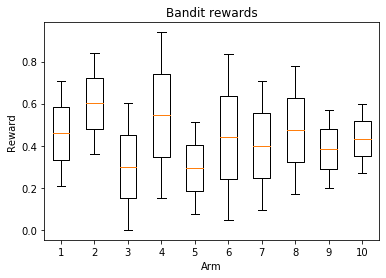

In [6]:
x = r_lwr+(r_upr-r_lwr)*np.linspace(0, 1)[:, None]
bp = plt.boxplot(x, whis='range')
plt.xlabel('Arm')
plt.ylabel('Reward')
plt.title('Bandit rewards')
plt.show()

C:\ProgramData\Anaconda3\envs\control\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


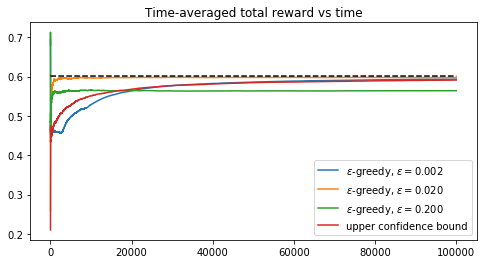

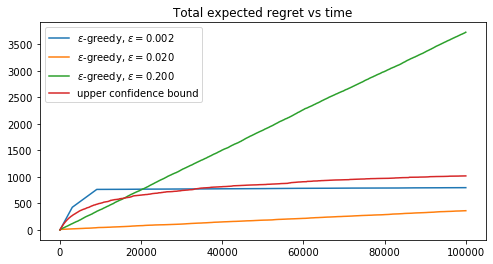

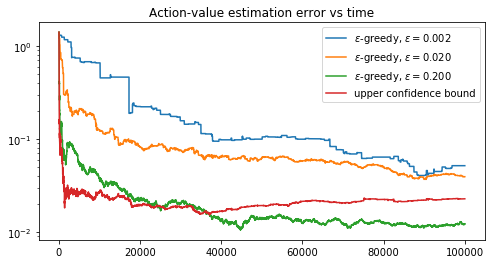

In [7]:
num_plots = 3
fig_list, ax_list = [], []
for i in range(num_plots):
    fig, ax = plt.subplots(figsize=(8,4))
    fig_list.append(fig)
    ax_list.append(ax)

for i, policy_string in enumerate(policy_strings):
    a_hist, r_hist, q_hist, n_hist, t_hist = experiment_data_list[i]

    # Reward history
    ax_list[0].plot(t_hist, np.cumsum(r_hist)/(t_hist+1))

    # Expected regret history
    r_hist_expected = np.array([q_opt[a] for a in a_hist.astype(int)])
    regret = q_opt.max() - r_hist_expected
    ax_list[1].plot(t_hist, np.cumsum(regret))

    # Action-value function estimation error
    ax_list[2].semilogy(t_hist, la.norm(q_hist-q_opt, axis=1))

ax_list[0].plot(t_hist, np.max(q_opt)*np.ones(nt), 'k--')

title_str_list = ['Time-averaged total reward vs time',
                  'Total expected regret vs time',
                  'Action-value estimation error vs time']
for ax, title_str in zip(ax_list, title_str_list):
    ax.set_title(title_str)
    ax.legend(policy_strings)
plt.show()